In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [9]:
import os
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
# from torchvision.transforms import ImageFolder
from torchvision.datasets import ImageFolder
from torchvision import transforms as T
from scipy.io import loadmat
from PIL import Image
from torchvision.models import resnet18, resnet50, efficientnet_b7,  inception_v3
import torchvision
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
import torch.optim as optim
from torch.nn.utils import clip_grad_norm_

# Dog Heart Vertebral Heart Size Point Detection 
# 1. Build an object detection model using pytorch

In [6]:
class DogHeartDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "Images"))))
        self.points = list(sorted(os.listdir(os.path.join(root, "Labels"))))

    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root, "Images", self.imgs[idx])
        points_path = os.path.join(self.root, "Labels", self.points[idx])
        img = Image.open(img_path).convert("RGB")
        w, h = img.size
        if self.transforms is not None:
            img = self.transforms(img)
        h_new, w_new = img.shape[1], img.shape[2]
        mat = loadmat(points_path)
        six_points = mat['six_points'].astype(float)
        six_points = torch.as_tensor(six_points, dtype=torch.float32)
        six_points[:, 0] = w_new / w * six_points[:, 0]  # Resize image to any size and maintain original points
        six_points[:, 1] = h_new / h * six_points[:, 1]
        six_points = torch.reshape(six_points, (-1,)) / h_new  # Normalize the points
        VHS = mat['VHS'].astype(float)
        VHS = torch.as_tensor(VHS, dtype=torch.float32)
        return img, six_points, VHS, self.imgs[idx]

    def __len__(self):
        return len(self.imgs)


def get_transform(resized_image_size, training=True):
    transforms = []
    transforms.append(T.Resize(size=(resized_image_size, resized_image_size)))
    transforms.append(T.ToTensor())
    transforms.append(T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]))
    return T.Compose(transforms)

train_path = '/kaggle/input/dog-vhs-dataset/Train'
valid_path = '/kaggle/input/dog-vhs-dataset/Valid'

## Read Train dataset using the dataloader
resized_image_size = 512
dataset_train = DogHeartDataset(train_path, get_transform(resized_image_size))
dataset_valid = DogHeartDataset(valid_path, get_transform(resized_image_size))


batch_size = 32
data_loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
data_loader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, shuffle= False,  num_workers=4, pin_memory=True)

# 2. Train your model using [Dog VHS Dataset](https://yuad-my.sharepoint.com/:f:/g/personal/youshan_zhang_yu_edu/ErguFJBE4y9KqzEdWWNlXzMBkTbsBaNX9l856SyvQauwJg?e=L3JOuN)

In [11]:
class CustomInceptionV3(nn.Module):
    def __init__(self, num_classes=12):
        super(CustomInceptionV3, self).__init__()
        # Load pre-trained Inception V3 model
        self.inception_V3 = inception_v3(weights=torchvision.models.Inception_V3_Weights.DEFAULT)
        
        # Modify the last fully connected layer
        in_features = self.inception_V3.fc.in_features
        self.inception_V3.fc = nn.Linear(in_features, num_classes)
        
    def forward(self, x):
        x = self.inception_V3(x)
        return x

# Initialize model
num_classes = 12
model = CustomInceptionV3(num_classes=num_classes)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

CustomInceptionV3(
  (inception_V3): Inception3(
    (Conv2d_1a_3x3): BasicConv2d(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_2a_3x3): BasicConv2d(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_2b_3x3): BasicConv2d(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (Conv2d_3b_1x1): BasicConv2d(
      (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_4

In [ ]:
torch.cuda.manual_seed(42)

train_losses = []
valid_losses = []

def train_step(model, train_data_loader, loss_function, optimizer, device):
    model.train()
    running_loss = 0.0
    for imgs, points, VHS in tqdm(train_data_loader):
        imgs, points, VHS = imgs.to(device), points.to(device), VHS.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        if isinstance(outputs, tuple):
            outputs = outputs[0]
        loss = loss_function(outputs, points)
        loss.backward()
        clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        running_loss += loss.item()
        imgs, points = imgs.cpu(), points.cpu()
        
        for i in range(len(VHS)):
            points_pred = outputs[i].view(1, -1)
            VHS_pred = calculate_vhs(points_pred)
            VHS_pred = VHS_pred

    epoch_loss = running_loss / len(train_data_loader)
    train_losses.append(epoch_loss)
    return epoch_loss

def valid_step(model, valid_data_loader, loss_function, device):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for imgs, points, VHS in tqdm(valid_data_loader):
            imgs, points, VHS = imgs.to(device), points.to(device), VHS.to(device)
            outputs = model(imgs)
            if isinstance(outputs, tuple):
                outputs = outputs[0]
            loss = loss_function(outputs, points)
            running_loss += loss.item()
            imgs, points = imgs.cpu(), points.cpu()
            
            for i in range(len(VHS)):
                points_pred = outputs[i].view(1, -1)
                VHS_pred = calculate_vhs(points_pred)
                VHS_pred = VHS_pred

    epoch_loss = running_loss / len(valid_data_loader)
    valid_losses.append(epoch_loss)
    return epoch_loss


In [ ]:
import pandas as pd
class DogHeartDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir(os.path.join(root, "Images"))))

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, "Images", self.imgs[idx])
        img = Image.open(img_path).convert("RGB")
        
        if self.transforms is not None:
            img = self.transforms(img)
        
        return img, img_path  # Return image and path as a string

    def __len__(self):
        return len(self.imgs)
    
def test_model(model, test_data_loader, csv_filename, device):
    model.eval()
    results = []
    
    for img, img_path in tqdm(test_data_loader):
        img = img.to(device)
        
        with torch.no_grad():
            # Get the original dimensions from the PIL image before any transformations
            pil_image = Image.open(img_path[0]).convert("RGB")
            w, h = pil_image.size
            
            points = model(img)
            points = torch.reshape(points, (-1, 2))
            points[:, 0] = w / resized_image_size * points[:, 0]
            points[:, 1] = h / resized_image_size * points[:, 1]
            
            points_tensor = points.view(-1)  # Flatten to 1D tensor
            vhs_score = round(calculate_vhs(points_tensor),6)
            
            # Save the results
            filename = os.path.basename(img_path[0])  # Extract filename from tuple
            results.append([filename, vhs_score])
    
    results_df = pd.DataFrame(results, columns=['filename', 'vhs_score'])
    results_df.to_csv(csv_filename, index=False)
    print(f'Results saved to {csv_filename}')

In [ ]:
# Define loss function
criterion = torch.nn.MSELoss()

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0001,weight_decay = 1e-4,amsgrad=True)

# scheduler = StepLR(optimizer, step_size=10, gamma=0.1)
scheduler = ReduceLROnPlateau(optimizer,mode='min',factor=0.1,patience =5, verbose = 1)

### Trained for 50 epochs 

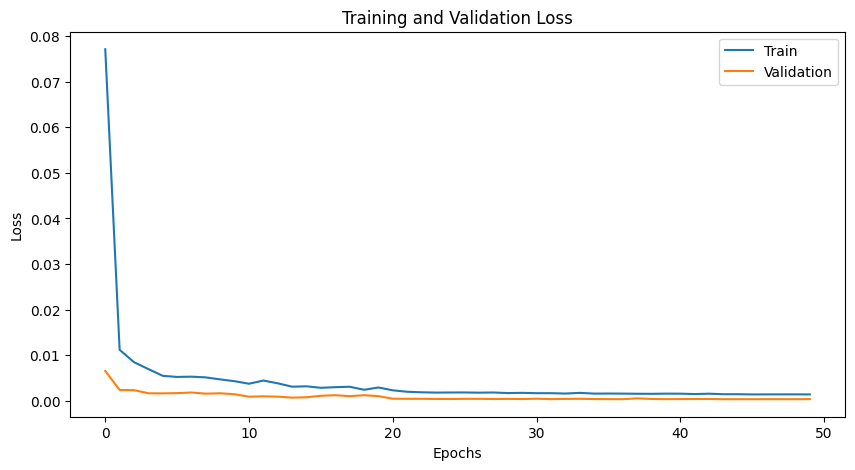

In [ ]:
# Plot train and validation loss
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(train_losses, label="Train")
plt.plot(valid_losses, label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
from tqdm import tqdm
num_epochs = 71
learning_rate = 0.0001

# Define loss function
criterion = torch.nn.MSELoss()

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0001,weight_decay = 1e-4,amsgrad=True)

# scheduler = StepLR(optimizer, step_size=10, gamma=0.1)
scheduler = ReduceLROnPlateau(optimizer,mode='min',factor=0.1,patience =5, verbose = 1)

# Load the checkpoint if exists
checkpoint_path = '/kaggle/input/inception-50-epochs/checkpoint_INCEP_50epochs.pth'
start_epoch = 0

if torch.cuda.is_available():
    device = torch.device('cuda')
    model = model.to(device)
    torch.cuda.manual_seed(42)
else:
    device = torch.device('cpu')

# Load the checkpoint
try:
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    train_losses = checkpoint.get('train_losses', [])
    valid_losses = checkpoint.get('valid_losses', [])
    print(f"Checkpoint loaded. Resuming training from epoch {start_epoch}")
    model.train()
except FileNotFoundError:
    print("No checkpoint found. Starting training from scratch.")
  


Checkpoint loaded. Resuming training from epoch 51


In [ ]:
# Training loop
for epoch in range(start_epoch, num_epochs):
    print(f"Epoch {epoch}/{num_epochs - 1}")
    
    train_loss = train_step(model, data_loader_train, criterion, optimizer, device)
    valid_loss = valid_step(model, data_loader_valid, criterion, device)

    print(f"Training Loss: {train_loss:.6f}, Validation Loss: {valid_loss:.6f}")

    # Step the scheduler
    scheduler.step(valid_loss)

Epoch 51/70


100%|██████████| 25/25 [00:09<00:00,  2.57it/s]


Training Loss: 0.004403, Validation Loss: 0.001550
Epoch 52/70


100%|██████████| 25/25 [00:06<00:00,  3.84it/s]


Training Loss: 0.002944, Validation Loss: 0.001179
Epoch 53/70


100%|██████████| 25/25 [00:06<00:00,  3.86it/s]


Training Loss: 0.002679, Validation Loss: 0.001132
Epoch 54/70


100%|██████████| 25/25 [00:06<00:00,  3.82it/s]


Training Loss: 0.002586, Validation Loss: 0.001128
Epoch 55/70


100%|██████████| 25/25 [00:06<00:00,  3.88it/s]


Training Loss: 0.002701, Validation Loss: 0.001216
Epoch 56/70


100%|██████████| 25/25 [00:06<00:00,  3.80it/s]


Training Loss: 0.002607, Validation Loss: 0.001096
Epoch 57/70


100%|██████████| 25/25 [00:06<00:00,  3.82it/s]


Training Loss: 0.002513, Validation Loss: 0.001118
Epoch 58/70


100%|██████████| 25/25 [00:06<00:00,  3.60it/s]


Training Loss: 0.002614, Validation Loss: 0.001100
Epoch 59/70


100%|██████████| 25/25 [00:06<00:00,  3.89it/s]


Training Loss: 0.002570, Validation Loss: 0.001087
Epoch 60/70


100%|██████████| 25/25 [00:06<00:00,  3.81it/s]


Training Loss: 0.002573, Validation Loss: 0.001213
Epoch 61/70


100%|██████████| 25/25 [00:06<00:00,  3.78it/s]


Training Loss: 0.002511, Validation Loss: 0.001158
Epoch 62/70


100%|██████████| 25/25 [00:06<00:00,  3.82it/s]


Training Loss: 0.002512, Validation Loss: 0.001015
Epoch 63/70


100%|██████████| 25/25 [00:06<00:00,  3.80it/s]


Training Loss: 0.002436, Validation Loss: 0.001064
Epoch 64/70


100%|██████████| 25/25 [00:06<00:00,  3.83it/s]


Training Loss: 0.002570, Validation Loss: 0.001096
Epoch 65/70


100%|██████████| 25/25 [00:06<00:00,  3.83it/s]


Training Loss: 0.002465, Validation Loss: 0.001132
Epoch 66/70


100%|██████████| 25/25 [00:06<00:00,  3.83it/s]


Training Loss: 0.002563, Validation Loss: 0.001071
Epoch 67/70


100%|██████████| 25/25 [00:06<00:00,  3.74it/s]


Training Loss: 0.002558, Validation Loss: 0.001118
Epoch 68/70


100%|██████████| 25/25 [00:06<00:00,  3.87it/s]


Training Loss: 0.002500, Validation Loss: 0.001089
Epoch 69/70


100%|██████████| 25/25 [00:06<00:00,  3.85it/s]


Training Loss: 0.002587, Validation Loss: 0.001045
Epoch 70/70


100%|██████████| 25/25 [00:06<00:00,  3.78it/s]

Training Loss: 0.002507, Validation Loss: 0.001086


In [ ]:
optimizer = optim.AdamW(model.parameters(), lr=0.0001,weight_decay = 1e-4,amsgrad=True)

In [ ]:
new_epochs = 80
for epoch in range(num_epochs, new_epochs):
    print(f"Epoch {epoch}/{new_epochs}")
    
    train_loss = train_step(model, data_loader_train, criterion, optimizer, device)
    valid_loss = valid_step(model, data_loader_valid, criterion, device)

    print(f"Training Loss: {train_loss:.6f}, Validation Loss: {valid_loss:.6f}")

    # Step the scheduler
    scheduler.step(valid_loss)

Epoch 71/80


100%|██████████| 25/25 [00:06<00:00,  3.72it/s]


Training Loss: 0.004764, Validation Loss: 0.001016
Epoch 72/80


100%|██████████| 25/25 [00:06<00:00,  3.89it/s]


Training Loss: 0.002448, Validation Loss: 0.000605
Epoch 73/80


100%|██████████| 25/25 [00:06<00:00,  3.90it/s]


Training Loss: 0.002063, Validation Loss: 0.000604
Epoch 74/80


100%|██████████| 25/25 [00:06<00:00,  3.92it/s]


Training Loss: 0.001846, Validation Loss: 0.000899
Epoch 75/80


100%|██████████| 25/25 [00:06<00:00,  3.83it/s]


Training Loss: 0.001611, Validation Loss: 0.000412
Epoch 76/80


100%|██████████| 25/25 [00:06<00:00,  3.91it/s]


Training Loss: 0.001485, Validation Loss: 0.000625
Epoch 77/80


100%|██████████| 25/25 [00:06<00:00,  3.83it/s]


Training Loss: 0.001397, Validation Loss: 0.000472
Epoch 78/80


100%|██████████| 25/25 [00:06<00:00,  3.94it/s]


Training Loss: 0.001320, Validation Loss: 0.000394
Epoch 79/80


100%|██████████| 25/25 [00:06<00:00,  3.93it/s]

Training Loss: 0.001195, Validation Loss: 0.000327


In [ ]:
new_epochs_1 = 100
for epoch in range(new_epochs, new_epochs_1):
    print(f"Epoch {epoch}/{new_epochs_1}")
    
    train_loss = train_step(model, data_loader_train, criterion, optimizer, device)
    valid_loss = valid_step(model, data_loader_valid, criterion, device)

    print(f"Training Loss: {train_loss:.6f}, Validation Loss: {valid_loss:.6f}")

    # Step the scheduler
    scheduler.step(valid_loss)

Epoch 80/100


100%|██████████| 25/25 [00:06<00:00,  3.76it/s]


Training Loss: 0.001079, Validation Loss: 0.000625
Epoch 81/100


100%|██████████| 25/25 [00:06<00:00,  3.81it/s]


Training Loss: 0.001099, Validation Loss: 0.000388
Epoch 82/100


100%|██████████| 25/25 [00:06<00:00,  3.92it/s]


Training Loss: 0.000974, Validation Loss: 0.000570
Epoch 83/100


100%|██████████| 25/25 [00:06<00:00,  3.90it/s]


Training Loss: 0.000968, Validation Loss: 0.000359
Epoch 84/100


100%|██████████| 25/25 [00:06<00:00,  3.84it/s]


Training Loss: 0.000925, Validation Loss: 0.000707
Epoch 85/100


100%|██████████| 25/25 [00:06<00:00,  3.83it/s]


Training Loss: 0.000886, Validation Loss: 0.000378
Epoch 86/100


100%|██████████| 25/25 [00:06<00:00,  3.91it/s]


Training Loss: 0.000884, Validation Loss: 0.000375
Epoch 87/100


100%|██████████| 25/25 [00:06<00:00,  3.86it/s]


Training Loss: 0.000838, Validation Loss: 0.000289
Epoch 88/100


100%|██████████| 25/25 [00:06<00:00,  3.89it/s]


Training Loss: 0.000800, Validation Loss: 0.000617
Epoch 89/100


100%|██████████| 25/25 [00:06<00:00,  3.90it/s]


Training Loss: 0.000767, Validation Loss: 0.000258
Epoch 90/100


100%|██████████| 25/25 [00:06<00:00,  3.87it/s]


Training Loss: 0.000749, Validation Loss: 0.000300
Epoch 91/100


100%|██████████| 25/25 [00:06<00:00,  3.89it/s]


Training Loss: 0.000736, Validation Loss: 0.000285
Epoch 92/100


100%|██████████| 25/25 [00:06<00:00,  3.91it/s]


Training Loss: 0.000718, Validation Loss: 0.000244
Epoch 93/100


100%|██████████| 25/25 [00:06<00:00,  3.80it/s]


Training Loss: 0.000679, Validation Loss: 0.000247
Epoch 94/100


100%|██████████| 25/25 [00:06<00:00,  3.85it/s]


Training Loss: 0.000708, Validation Loss: 0.000241
Epoch 95/100


100%|██████████| 25/25 [00:06<00:00,  3.89it/s]


Training Loss: 0.000671, Validation Loss: 0.000276
Epoch 96/100


100%|██████████| 25/25 [00:06<00:00,  3.83it/s]


Training Loss: 0.000640, Validation Loss: 0.000310
Epoch 97/100


100%|██████████| 25/25 [00:06<00:00,  3.86it/s]


Training Loss: 0.000640, Validation Loss: 0.000349
Epoch 98/100


100%|██████████| 25/25 [00:06<00:00,  3.87it/s]


Training Loss: 0.000636, Validation Loss: 0.000231
Epoch 99/100


100%|██████████| 25/25 [00:06<00:00,  3.81it/s]

Training Loss: 0.000600, Validation Loss: 0.000297


In [ ]:
new_epochs_2 = 120
for epoch in range(new_epochs_1, new_epochs_2):
    print(f"Epoch {epoch}/{new_epochs_2}")
    
    train_loss = train_step(model, data_loader_train, criterion, optimizer, device)
    valid_loss = valid_step(model, data_loader_valid, criterion, device)

    print(f"Training Loss: {train_loss:.6f}, Validation Loss: {valid_loss:.6f}")

    # Step the scheduler
    scheduler.step(valid_loss)

Epoch 100/120


100%|██████████| 25/25 [00:06<00:00,  3.80it/s]


Training Loss: 0.000613, Validation Loss: 0.000232
Epoch 101/120


100%|██████████| 25/25 [00:06<00:00,  3.83it/s]


Training Loss: 0.000586, Validation Loss: 0.000256
Epoch 102/120


100%|██████████| 25/25 [00:06<00:00,  3.89it/s]


Training Loss: 0.000564, Validation Loss: 0.000236
Epoch 103/120


100%|██████████| 25/25 [00:06<00:00,  3.92it/s]


Training Loss: 0.000595, Validation Loss: 0.000205
Epoch 104/120


100%|██████████| 25/25 [00:06<00:00,  3.90it/s]


Training Loss: 0.000547, Validation Loss: 0.000233
Epoch 105/120


100%|██████████| 25/25 [00:06<00:00,  3.93it/s]


Training Loss: 0.000540, Validation Loss: 0.000531
Epoch 106/120


100%|██████████| 25/25 [00:06<00:00,  3.89it/s]


Training Loss: 0.000538, Validation Loss: 0.000277
Epoch 107/120


100%|██████████| 25/25 [00:06<00:00,  3.90it/s]


Training Loss: 0.000542, Validation Loss: 0.000223
Epoch 108/120


100%|██████████| 25/25 [00:06<00:00,  3.91it/s]


Training Loss: 0.000526, Validation Loss: 0.000310
Epoch 109/120


100%|██████████| 25/25 [00:06<00:00,  3.81it/s]


Training Loss: 0.000526, Validation Loss: 0.000268
Epoch 110/120


100%|██████████| 25/25 [00:06<00:00,  3.83it/s]


Training Loss: 0.000504, Validation Loss: 0.000262
Epoch 111/120


100%|██████████| 25/25 [00:06<00:00,  3.92it/s]


Training Loss: 0.000489, Validation Loss: 0.000212
Epoch 112/120


100%|██████████| 25/25 [00:06<00:00,  3.98it/s]


Training Loss: 0.000497, Validation Loss: 0.000236
Epoch 113/120


100%|██████████| 25/25 [00:06<00:00,  3.89it/s]


Training Loss: 0.000488, Validation Loss: 0.000214
Epoch 114/120


100%|██████████| 25/25 [00:06<00:00,  3.84it/s]


Training Loss: 0.000491, Validation Loss: 0.000225
Epoch 115/120


100%|██████████| 25/25 [00:06<00:00,  3.91it/s]


Training Loss: 0.000490, Validation Loss: 0.000241
Epoch 116/120


100%|██████████| 25/25 [00:06<00:00,  3.84it/s]


Training Loss: 0.000491, Validation Loss: 0.000238
Epoch 117/120


100%|██████████| 25/25 [00:06<00:00,  3.93it/s]


Training Loss: 0.000460, Validation Loss: 0.000323
Epoch 118/120


100%|██████████| 25/25 [00:06<00:00,  3.91it/s]


Training Loss: 0.000481, Validation Loss: 0.000211
Epoch 119/120


100%|██████████| 25/25 [00:06<00:00,  3.78it/s]

Training Loss: 0.000447, Validation Loss: 0.000217


In [ ]:
new_epochs_3 = 150
for epoch in range(new_epochs_2, new_epochs_3):
    print(f"Epoch {epoch}/{new_epochs_3}")
    
    train_loss = train_step(model, data_loader_train, criterion, optimizer, device)
    valid_loss = valid_step(model, data_loader_valid, criterion, device)

    print(f"Training Loss: {train_loss:.6f}, Validation Loss: {valid_loss:.6f}")

    # Step the scheduler
    scheduler.step(valid_loss)

Epoch 120/150


100%|██████████| 25/25 [00:06<00:00,  3.88it/s]


Training Loss: 0.000467, Validation Loss: 0.000227
Epoch 121/150


100%|██████████| 25/25 [00:06<00:00,  3.87it/s]


Training Loss: 0.000461, Validation Loss: 0.000215
Epoch 122/150


100%|██████████| 25/25 [00:06<00:00,  3.90it/s]


Training Loss: 0.000441, Validation Loss: 0.000282
Epoch 123/150


100%|██████████| 25/25 [00:06<00:00,  3.87it/s]


Training Loss: 0.000430, Validation Loss: 0.000217
Epoch 124/150


100%|██████████| 25/25 [00:06<00:00,  3.94it/s]


Training Loss: 0.000456, Validation Loss: 0.000219
Epoch 125/150


100%|██████████| 25/25 [00:06<00:00,  3.92it/s]


Training Loss: 0.000445, Validation Loss: 0.000247
Epoch 126/150


100%|██████████| 25/25 [00:06<00:00,  3.74it/s]


Training Loss: 0.000440, Validation Loss: 0.000201
Epoch 127/150


100%|██████████| 25/25 [00:06<00:00,  3.84it/s]


Training Loss: 0.000429, Validation Loss: 0.000259
Epoch 128/150


100%|██████████| 25/25 [00:06<00:00,  3.86it/s]


Training Loss: 0.000434, Validation Loss: 0.000206
Epoch 129/150


100%|██████████| 25/25 [00:06<00:00,  3.78it/s]


Training Loss: 0.000441, Validation Loss: 0.000240
Epoch 130/150


100%|██████████| 25/25 [00:06<00:00,  3.85it/s]


Training Loss: 0.000417, Validation Loss: 0.000227
Epoch 131/150


100%|██████████| 25/25 [00:06<00:00,  3.85it/s]


Training Loss: 0.000440, Validation Loss: 0.000201
Epoch 132/150


100%|██████████| 25/25 [00:06<00:00,  3.89it/s]


Training Loss: 0.000423, Validation Loss: 0.000213
Epoch 133/150


100%|██████████| 25/25 [00:06<00:00,  3.89it/s]


Training Loss: 0.000422, Validation Loss: 0.000209
Epoch 134/150


100%|██████████| 25/25 [00:06<00:00,  4.00it/s]


Training Loss: 0.000434, Validation Loss: 0.000256
Epoch 135/150


100%|██████████| 25/25 [00:06<00:00,  3.82it/s]


Training Loss: 0.000430, Validation Loss: 0.000198
Epoch 136/150


100%|██████████| 25/25 [00:06<00:00,  3.88it/s]


Training Loss: 0.000402, Validation Loss: 0.000210
Epoch 137/150


100%|██████████| 25/25 [00:06<00:00,  3.72it/s]


Training Loss: 0.000418, Validation Loss: 0.000249
Epoch 138/150


100%|██████████| 25/25 [00:06<00:00,  3.89it/s]


Training Loss: 0.000405, Validation Loss: 0.000206
Epoch 139/150


100%|██████████| 25/25 [00:06<00:00,  3.81it/s]


Training Loss: 0.000388, Validation Loss: 0.000210
Epoch 140/150


100%|██████████| 25/25 [00:06<00:00,  3.87it/s]


Training Loss: 0.000405, Validation Loss: 0.000219
Epoch 141/150


100%|██████████| 25/25 [00:06<00:00,  3.90it/s]


Training Loss: 0.000406, Validation Loss: 0.000205
Epoch 142/150


100%|██████████| 25/25 [00:06<00:00,  3.98it/s]


Training Loss: 0.000385, Validation Loss: 0.000196
Epoch 143/150


100%|██████████| 25/25 [00:06<00:00,  3.95it/s]


Training Loss: 0.000404, Validation Loss: 0.000187
Epoch 144/150


100%|██████████| 25/25 [00:06<00:00,  3.84it/s]


Training Loss: 0.000371, Validation Loss: 0.000206
Epoch 145/150


100%|██████████| 25/25 [00:06<00:00,  3.95it/s]


Training Loss: 0.000391, Validation Loss: 0.000225
Epoch 146/150


100%|██████████| 25/25 [00:06<00:00,  3.83it/s]


Training Loss: 0.000377, Validation Loss: 0.000190
Epoch 147/150


100%|██████████| 25/25 [00:06<00:00,  3.81it/s]


Training Loss: 0.000374, Validation Loss: 0.000207
Epoch 148/150


100%|██████████| 25/25 [00:06<00:00,  3.87it/s]


Training Loss: 0.000368, Validation Loss: 0.000200
Epoch 149/150


100%|██████████| 25/25 [00:06<00:00,  3.91it/s]

Training Loss: 0.000393, Validation Loss: 0.000202


In [ ]:
new_epochs_4 = 180
for epoch in range(new_epochs_3, new_epochs_4):
    print(f"Epoch {epoch}/{new_epochs_4}")
    
    train_loss = train_step(model, data_loader_train, criterion, optimizer, device)
    valid_loss = valid_step(model, data_loader_valid, criterion, device)

    print(f"Training Loss: {train_loss:.6f}, Validation Loss: {valid_loss:.6f}")

    # Step the scheduler
    scheduler.step(valid_loss)
    


Epoch 150/180


100%|██████████| 25/25 [00:06<00:00,  3.81it/s]


Training Loss: 0.000379, Validation Loss: 0.000334
Epoch 151/180


100%|██████████| 25/25 [00:06<00:00,  3.73it/s]


Training Loss: 0.000388, Validation Loss: 0.000242
Epoch 152/180


100%|██████████| 25/25 [00:06<00:00,  3.78it/s]


Training Loss: 0.000378, Validation Loss: 0.000189
Epoch 153/180


100%|██████████| 25/25 [00:06<00:00,  3.81it/s]


Training Loss: 0.000391, Validation Loss: 0.000235
Epoch 154/180


100%|██████████| 25/25 [00:06<00:00,  3.70it/s]


Training Loss: 0.000371, Validation Loss: 0.000204
Epoch 155/180


100%|██████████| 25/25 [00:06<00:00,  3.77it/s]


Training Loss: 0.000359, Validation Loss: 0.000187
Epoch 156/180


100%|██████████| 25/25 [00:06<00:00,  3.86it/s]


Training Loss: 0.000382, Validation Loss: 0.000247
Epoch 157/180


100%|██████████| 25/25 [00:06<00:00,  3.82it/s]


Training Loss: 0.000380, Validation Loss: 0.000206
Epoch 158/180


100%|██████████| 25/25 [00:06<00:00,  3.89it/s]


Training Loss: 0.000365, Validation Loss: 0.000199
Epoch 159/180


100%|██████████| 25/25 [00:06<00:00,  3.75it/s]


Training Loss: 0.000359, Validation Loss: 0.000244
Epoch 160/180


100%|██████████| 25/25 [00:06<00:00,  3.87it/s]


Training Loss: 0.000363, Validation Loss: 0.000212
Reduced learning rate to 1e-05
Epoch 161/180


100%|██████████| 25/25 [00:06<00:00,  3.85it/s]


Training Loss: 0.000333, Validation Loss: 0.000180
Epoch 162/180


100%|██████████| 25/25 [00:06<00:00,  3.86it/s]


Training Loss: 0.000329, Validation Loss: 0.000175
Epoch 163/180


100%|██████████| 25/25 [00:06<00:00,  3.81it/s]


Training Loss: 0.000316, Validation Loss: 0.000188
Epoch 164/180


100%|██████████| 25/25 [00:06<00:00,  3.79it/s]


Training Loss: 0.000322, Validation Loss: 0.000177
Epoch 165/180


100%|██████████| 25/25 [00:06<00:00,  3.85it/s]


Training Loss: 0.000333, Validation Loss: 0.000174
Epoch 166/180


100%|██████████| 25/25 [00:06<00:00,  3.75it/s]


Training Loss: 0.000319, Validation Loss: 0.000171
Epoch 167/180


100%|██████████| 25/25 [00:06<00:00,  3.81it/s]


Training Loss: 0.000319, Validation Loss: 0.000183
Epoch 168/180


100%|██████████| 25/25 [00:06<00:00,  3.67it/s]


Training Loss: 0.000304, Validation Loss: 0.000169
Epoch 169/180


100%|██████████| 25/25 [00:06<00:00,  3.76it/s]


Training Loss: 0.000309, Validation Loss: 0.000176
Epoch 170/180


100%|██████████| 25/25 [00:06<00:00,  3.80it/s]


Training Loss: 0.000307, Validation Loss: 0.000176
Reduced learning rate to 1.0000000000000002e-06
Epoch 171/180


100%|██████████| 25/25 [00:06<00:00,  3.62it/s]


Training Loss: 0.000306, Validation Loss: 0.000174
Epoch 172/180


100%|██████████| 25/25 [00:06<00:00,  3.78it/s]


Training Loss: 0.000313, Validation Loss: 0.000172
Epoch 173/180


100%|██████████| 25/25 [00:06<00:00,  3.86it/s]


Training Loss: 0.000297, Validation Loss: 0.000170
Epoch 174/180


100%|██████████| 25/25 [00:06<00:00,  3.90it/s]


Training Loss: 0.000310, Validation Loss: 0.000173
Epoch 175/180


100%|██████████| 25/25 [00:06<00:00,  3.82it/s]


Training Loss: 0.000291, Validation Loss: 0.000172
Epoch 176/180


100%|██████████| 25/25 [00:06<00:00,  3.80it/s]


Training Loss: 0.000303, Validation Loss: 0.000172
Epoch 177/180


100%|██████████| 25/25 [00:06<00:00,  3.82it/s]


Training Loss: 0.000307, Validation Loss: 0.000174
Epoch 178/180


100%|██████████| 25/25 [00:06<00:00,  3.63it/s]


Training Loss: 0.000291, Validation Loss: 0.000172
Epoch 179/180


100%|██████████| 25/25 [00:06<00:00,  3.90it/s]

Training Loss: 0.000308, Validation Loss: 0.000175


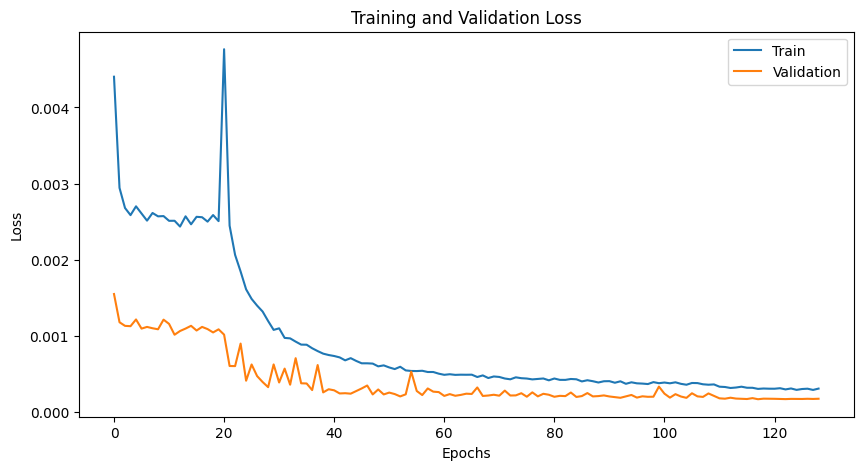

In [ ]:
# Plot train and validation loss
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(train_losses, label="Train")
plt.plot(valid_losses, label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
num_epochs = 240

# Define loss function
criterion = torch.nn.MSELoss()

# Define optimizer
optimizer = optim.AdamW(model.parameters(), lr=0.0005,weight_decay = 1e-4,amsgrad=True)

# scheduler = StepLR(optimizer, step_size=10, gamma=0.1)
scheduler = ReduceLROnPlateau(optimizer,mode='min',factor=0.1,patience =5, verbose = 1)

# Load the checkpoint if exists
checkpoint_path = '/kaggle/working/checkpoint_InceptionV3_110epochs.pth'
start_epoch = 180

if torch.cuda.is_available():
    device = torch.device('cuda')
    model = model.to(device)
    torch.cuda.manual_seed(42)
else:
    device = torch.device('cpu')

# Load the checkpoint
try:
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    train_losses = checkpoint.get('train_losses', [])
    valid_losses = checkpoint.get('valid_losses', [])
    print(f"Checkpoint loaded. Resuming training from epoch {start_epoch}")
    model.train()
except FileNotFoundError:
    print("No checkpoint found. Starting training from scratch.")
    train_losses = []
    valid_losses = []
model.train()

Checkpoint loaded. Resuming training from epoch 180


CustomInceptionV3(
  (inception_V3): Inception3(
    (Conv2d_1a_3x3): BasicConv2d(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_2a_3x3): BasicConv2d(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_2b_3x3): BasicConv2d(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (Conv2d_3b_1x1): BasicConv2d(
      (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_4

In [ ]:
# Training loop
for epoch in range(start_epoch, num_epochs):
    print(f"Epoch {epoch}/{num_epochs }")
    
    train_loss = train_step(model, data_loader_train, criterion, optimizer, device)
    valid_loss = valid_step(model, data_loader_valid, criterion, device)
    # Step the scheduler
    scheduler.step(valid_loss)
    
    print(f"Training Loss: {train_loss:.6f}, Validation Loss: {valid_loss:.6f}")
    

Epoch 180/240


100%|██████████| 7/7 [00:07<00:00,  1.00s/it]


Training Loss: 0.000352, Validation Loss: 0.000263
Epoch 181/240


100%|██████████| 7/7 [00:07<00:00,  1.00s/it]


Training Loss: 0.000311, Validation Loss: 0.000221
Epoch 182/240


100%|██████████| 7/7 [00:07<00:00,  1.03s/it]


Training Loss: 0.000315, Validation Loss: 0.000179
Epoch 183/240


100%|██████████| 7/7 [00:06<00:00,  1.00it/s]


Training Loss: 0.000307, Validation Loss: 0.000197
Epoch 184/240


100%|██████████| 7/7 [00:07<00:00,  1.04s/it]


Training Loss: 0.000306, Validation Loss: 0.000174
Epoch 185/240


100%|██████████| 7/7 [00:07<00:00,  1.00s/it]


Training Loss: 0.000299, Validation Loss: 0.000191
Epoch 186/240


100%|██████████| 7/7 [00:07<00:00,  1.02s/it]


Training Loss: 0.000294, Validation Loss: 0.000189
Epoch 187/240


100%|██████████| 7/7 [00:06<00:00,  1.01it/s]


Epoch 00015: reducing learning rate of group 0 to 2.5000e-06.
Training Loss: 0.000302, Validation Loss: 0.000180
Epoch 188/240


100%|██████████| 7/7 [00:06<00:00,  1.03it/s]


Training Loss: 0.000297, Validation Loss: 0.000170
Epoch 189/240


100%|██████████| 7/7 [00:07<00:00,  1.00s/it]


Training Loss: 0.000280, Validation Loss: 0.000169
Epoch 190/240


100%|██████████| 7/7 [00:06<00:00,  1.04it/s]


Training Loss: 0.000277, Validation Loss: 0.000169
Epoch 191/240


100%|██████████| 7/7 [00:06<00:00,  1.02it/s]


Training Loss: 0.000287, Validation Loss: 0.000170
Epoch 192/240


100%|██████████| 7/7 [00:06<00:00,  1.03it/s]


Training Loss: 0.000287, Validation Loss: 0.000168
Epoch 193/240


100%|██████████| 7/7 [00:06<00:00,  1.01it/s]


Training Loss: 0.000291, Validation Loss: 0.000169
Epoch 194/240


100%|██████████| 7/7 [00:06<00:00,  1.02it/s]


Training Loss: 0.000287, Validation Loss: 0.000167
Epoch 195/240


100%|██████████| 7/7 [00:06<00:00,  1.01it/s]


Training Loss: 0.000289, Validation Loss: 0.000167
Epoch 196/240


100%|██████████| 7/7 [00:06<00:00,  1.03it/s]


Training Loss: 0.000288, Validation Loss: 0.000169
Epoch 197/240


100%|██████████| 7/7 [00:06<00:00,  1.02it/s]


Epoch 00035: reducing learning rate of group 0 to 1.2500e-07.
Training Loss: 0.000283, Validation Loss: 0.000171
Epoch 198/240


100%|██████████| 7/7 [00:06<00:00,  1.03it/s]


Training Loss: 0.000279, Validation Loss: 0.000170
Epoch 199/240


100%|██████████| 7/7 [00:06<00:00,  1.02it/s]


Training Loss: 0.000288, Validation Loss: 0.000168
Epoch 200/240


100%|██████████| 7/7 [00:06<00:00,  1.04it/s]


Epoch 00041: reducing learning rate of group 0 to 1.2500e-08.
Training Loss: 0.000283, Validation Loss: 0.000168
Epoch 201/240


100%|██████████| 7/7 [00:06<00:00,  1.02it/s]


Training Loss: 0.000285, Validation Loss: 0.000168
Epoch 202/240


100%|██████████| 7/7 [00:06<00:00,  1.00it/s]


Training Loss: 0.000275, Validation Loss: 0.000168
Epoch 203/240


100%|██████████| 7/7 [00:06<00:00,  1.01it/s]


Training Loss: 0.000282, Validation Loss: 0.000168
Epoch 204/240


100%|██████████| 7/7 [00:06<00:00,  1.01it/s]


Training Loss: 0.000281, Validation Loss: 0.000168
Epoch 205/240


100%|██████████| 7/7 [00:06<00:00,  1.05it/s]


Training Loss: 0.000290, Validation Loss: 0.000168
Epoch 206/240


100%|██████████| 7/7 [00:06<00:00,  1.03it/s]


Training Loss: 0.000279, Validation Loss: 0.000169
Epoch 207/240


100%|██████████| 7/7 [00:06<00:00,  1.02it/s]


Training Loss: 0.000279, Validation Loss: 0.000167
Epoch 208/240


100%|██████████| 7/7 [00:06<00:00,  1.04it/s]


Training Loss: 0.000286, Validation Loss: 0.000169
Epoch 209/240


100%|██████████| 7/7 [00:06<00:00,  1.03it/s]


Training Loss: 0.000285, Validation Loss: 0.000168
Epoch 210/240


100%|██████████| 7/7 [00:06<00:00,  1.02it/s]


Training Loss: 0.000279, Validation Loss: 0.000168
Epoch 211/240


100%|██████████| 7/7 [00:06<00:00,  1.04it/s]


Training Loss: 0.000281, Validation Loss: 0.000169
Epoch 212/240


100%|██████████| 7/7 [00:06<00:00,  1.03it/s]


Training Loss: 0.000278, Validation Loss: 0.000168
Epoch 213/240


100%|██████████| 7/7 [00:07<00:00,  1.00s/it]


Training Loss: 0.000292, Validation Loss: 0.000168
Epoch 214/240


100%|██████████| 7/7 [00:06<00:00,  1.03it/s]


Training Loss: 0.000290, Validation Loss: 0.000167
Epoch 215/240


100%|██████████| 7/7 [00:06<00:00,  1.01it/s]


Training Loss: 0.000291, Validation Loss: 0.000168
Epoch 216/240


100%|██████████| 7/7 [00:06<00:00,  1.04it/s]


Training Loss: 0.000281, Validation Loss: 0.000168
Epoch 217/240


100%|██████████| 7/7 [00:06<00:00,  1.01it/s]


Training Loss: 0.000288, Validation Loss: 0.000168
Epoch 218/240


100%|██████████| 7/7 [00:06<00:00,  1.02it/s]


Training Loss: 0.000281, Validation Loss: 0.000168
Epoch 219/240


100%|██████████| 7/7 [00:06<00:00,  1.01it/s]


Training Loss: 0.000280, Validation Loss: 0.000168
Epoch 220/240


100%|██████████| 7/7 [00:07<00:00,  1.02s/it]


Training Loss: 0.000278, Validation Loss: 0.000169
Epoch 221/240


100%|██████████| 7/7 [00:06<00:00,  1.01it/s]


Training Loss: 0.000280, Validation Loss: 0.000168
Epoch 222/240


100%|██████████| 7/7 [00:06<00:00,  1.00it/s]


Training Loss: 0.000284, Validation Loss: 0.000168
Epoch 223/240


100%|██████████| 7/7 [00:06<00:00,  1.03it/s]


Training Loss: 0.000280, Validation Loss: 0.000168
Epoch 224/240


100%|██████████| 7/7 [00:06<00:00,  1.04it/s]


Training Loss: 0.000279, Validation Loss: 0.000168
Epoch 225/240


100%|██████████| 7/7 [00:07<00:00,  1.00s/it]


Training Loss: 0.000284, Validation Loss: 0.000168
Epoch 226/240


100%|██████████| 7/7 [00:07<00:00,  1.00s/it]


Training Loss: 0.000279, Validation Loss: 0.000169
Epoch 227/240


100%|██████████| 7/7 [00:06<00:00,  1.02it/s]


Training Loss: 0.000288, Validation Loss: 0.000168
Epoch 228/240


100%|██████████| 7/7 [00:06<00:00,  1.03it/s]


Training Loss: 0.000273, Validation Loss: 0.000168
Epoch 229/240


100%|██████████| 7/7 [00:06<00:00,  1.05it/s]


Training Loss: 0.000282, Validation Loss: 0.000168
Epoch 230/240


100%|██████████| 7/7 [00:06<00:00,  1.03it/s]


Training Loss: 0.000278, Validation Loss: 0.000168
Epoch 231/240


100%|██████████| 7/7 [00:06<00:00,  1.05it/s]


Training Loss: 0.000274, Validation Loss: 0.000168
Epoch 232/240


100%|██████████| 7/7 [00:06<00:00,  1.03it/s]


Training Loss: 0.000274, Validation Loss: 0.000168
Epoch 233/240


100%|██████████| 7/7 [00:06<00:00,  1.04it/s]


Training Loss: 0.000283, Validation Loss: 0.000168
Epoch 234/240


100%|██████████| 7/7 [00:06<00:00,  1.03it/s]


Training Loss: 0.000280, Validation Loss: 0.000169
Epoch 235/240


100%|██████████| 7/7 [00:06<00:00,  1.04it/s]


Training Loss: 0.000266, Validation Loss: 0.000167
Epoch 236/240


100%|██████████| 7/7 [00:06<00:00,  1.03it/s]


Training Loss: 0.000272, Validation Loss: 0.000168
Epoch 237/240


100%|██████████| 7/7 [00:06<00:00,  1.03it/s]


Training Loss: 0.000277, Validation Loss: 0.000168
Epoch 238/240


100%|██████████| 7/7 [00:06<00:00,  1.04it/s]


Training Loss: 0.000292, Validation Loss: 0.000168
Epoch 239/240


100%|██████████| 7/7 [00:06<00:00,  1.02it/s]

Training Loss: 0.000279, Validation Loss: 0.000168


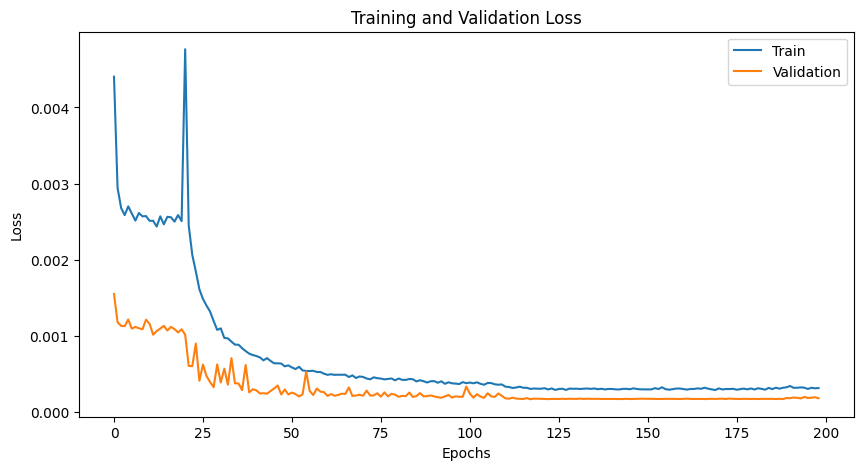

In [ ]:
# Plot train and validation loss
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(train_losses, label="Train")
plt.plot(valid_losses, label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
torch.save({
    'epoch': epoch,  # Current epoch
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    'train_loss': train_losses,
    'valid_loss': valid_losses,
}, 'checkpoint_InceptionV3_240ep.pth')

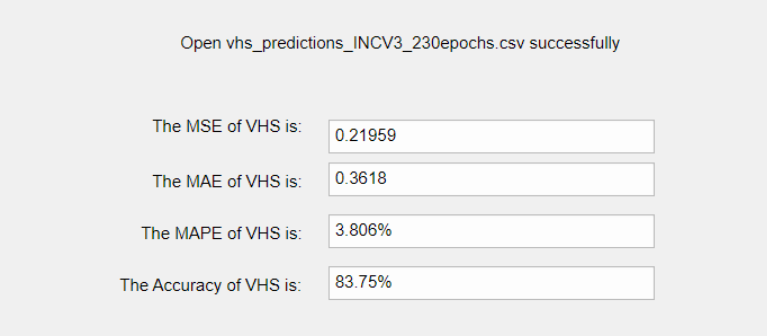

In [12]:
# Define loss function
criterion = torch.nn.MSELoss()

# Define optimizer
optimizer = optim.AdamW(model.parameters(), lr=0.0005,weight_decay = 1e-4,amsgrad=True)

# scheduler = StepLR(optimizer, step_size=10, gamma=0.1)
scheduler = ReduceLROnPlateau(optimizer,mode='min',factor=0.1,patience =5, verbose = 1)

# Load the checkpoint if exists
checkpoint_path = '/kaggle/input/inceptionv3/checkpoint_InceptionV3_240ep.pth'
start_epoch = 0

if torch.cuda.is_available():
    device = torch.device('cuda')
    model = model.to(device)
    torch.cuda.manual_seed(42)
else:
    device = torch.device('cpu')

# Load the checkpoint
try:
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'], strict=False)
    
    # Reinitialize the optimizer
    optimizer = optim.AdamW(model.parameters(), lr=0.0005, weight_decay=1e-4, amsgrad=True)
    
    # Load the scheduler state
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    train_losses = checkpoint.get('train_losses', [])
    valid_losses = checkpoint.get('valid_losses', [])
    print(f"Checkpoint loaded. Resuming training from epoch {start_epoch}")
    model.train()
except FileNotFoundError:
    print("No checkpoint found. Starting training from scratch.")
    train_losses = []
    valid_losses = []


Checkpoint loaded. Resuming training from epoch 240


In [13]:
print(optimizer)

AdamW (
Parameter Group 0
    amsgrad: True
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0005
    maximize: False
    weight_decay: 0.0001
)


In [14]:
def calculate_vhs(points):
    # Ensure the points are tensors and clone to detach from the computation graph
    points = points.clone().detach()

    # Extract individual points
    P1, P2 = points[0:2], points[2:4]
    P3, P4 = points[4:6], points[6:8]
    P5, P6 = points[8:10], points[10:12]

    # Calculate distances
    AB = torch.norm(P1 - P2)
    CD = torch.norm(P3 - P4)
    EF = torch.norm(P5 - P6)

    vhs = 6 * (AB + CD) / EF
    return vhs.item()

def save_model(model, optimizer, scheduler, epoch, path):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict() if scheduler is not None else None,
    }, path)

In [21]:
# Define loss function
criterion = torch.nn.MSELoss()

# Define optimizer
optimizer = optim.AdamW(model.parameters(), lr=2e-5, weight_decay = 1e-5,amsgrad=True)

# scheduler = StepLR(optimizer, step_size=10, gamma=0.1)
scheduler = ReduceLROnPlateau(optimizer,mode='min',factor=0.1,patience =5, verbose = 1)

In [15]:
torch.cuda.manual_seed(42)

train_losses = []
valid_losses = []

def train_step(model, train_data_loader, loss_function, optimizer, device):
    model.train()
    running_loss = 0.0
    for imgs, points, VHS in tqdm(train_data_loader):
        imgs, points, VHS = imgs.to(device), points.to(device), VHS.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        if isinstance(outputs, tuple):
            outputs = outputs[0]
        loss = loss_function(outputs, points)
        loss.backward()
        clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        running_loss += loss.item()
        imgs, points = imgs.cpu(), points.cpu()
        
        for i in range(len(VHS)):
            points_pred = outputs[i].view(1, -1)
            VHS_pred = calculate_vhs(points_pred)
            VHS_pred = VHS_pred

    epoch_loss = running_loss / len(train_data_loader)
    train_losses.append(epoch_loss)
    return epoch_loss

def valid_step(model, valid_data_loader, loss_function, device):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for imgs, points, VHS in tqdm(valid_data_loader):
            imgs, points, VHS = imgs.to(device), points.to(device), VHS.to(device)
            outputs = model(imgs)
            if isinstance(outputs, tuple):
                outputs = outputs[0]
            loss = loss_function(outputs, points)
            running_loss += loss.item()
            imgs, points = imgs.cpu(), points.cpu()
            
            for i in range(len(VHS)):
                points_pred = outputs[i].view(1, -1)
                VHS_pred = calculate_vhs(points_pred)
                VHS_pred = VHS_pred

    epoch_loss = running_loss / len(valid_data_loader)
    valid_losses.append(epoch_loss)
    return epoch_loss

In [16]:
from tqdm import tqdm
num_epochs = 260
for epoch in range(start_epoch, num_epochs):
    print(f"Epoch {epoch}/{num_epochs }")
    
    train_loss = train_step(model, data_loader_train, criterion, optimizer, device)
    valid_loss = valid_step(model, data_loader_valid, criterion, device)
    # Step the scheduler
    scheduler.step(valid_loss)
    if epoch % 10 == 0:
        for param_group in optimizer.param_groups:
            param_group['lr'] = param_group['lr'] * 0.5  # Halve the learning rate
    print(f"Training Loss: {train_loss:.6f}, Validation Loss: {valid_loss:.6f}")
    # Step the scheduler

Epoch 240/260


100%|██████████| 7/7 [00:03<00:00,  1.87it/s]


Training Loss: 0.002760, Validation Loss: 0.001002
Epoch 241/260


100%|██████████| 7/7 [00:03<00:00,  1.78it/s]


Training Loss: 0.000832, Validation Loss: 0.000369
Epoch 242/260


100%|██████████| 7/7 [00:03<00:00,  1.89it/s]


Epoch 00123: reducing learning rate of group 0 to 5.0000e-05.
Training Loss: 0.000735, Validation Loss: 0.000597
Epoch 243/260


100%|██████████| 7/7 [00:03<00:00,  1.83it/s]


Training Loss: 0.000722, Validation Loss: 0.000406
Epoch 244/260


100%|██████████| 7/7 [00:03<00:00,  1.82it/s]


Training Loss: 0.000681, Validation Loss: 0.000288
Epoch 245/260


100%|██████████| 7/7 [00:03<00:00,  1.86it/s]


Training Loss: 0.000601, Validation Loss: 0.001617
Epoch 246/260


100%|██████████| 7/7 [00:03<00:00,  1.77it/s]


Training Loss: 0.000546, Validation Loss: 0.000851
Epoch 247/260


100%|██████████| 7/7 [00:03<00:00,  1.80it/s]


Training Loss: 0.000609, Validation Loss: 0.000379
Epoch 248/260


100%|██████████| 7/7 [00:03<00:00,  1.82it/s]


Epoch 00129: reducing learning rate of group 0 to 5.0000e-06.
Training Loss: 0.000592, Validation Loss: 0.000458
Epoch 249/260


100%|██████████| 7/7 [00:03<00:00,  1.87it/s]


Training Loss: 0.000507, Validation Loss: 0.000418
Epoch 250/260


100%|██████████| 7/7 [00:03<00:00,  1.88it/s]


Training Loss: 0.000483, Validation Loss: 0.000768
Epoch 251/260


100%|██████████| 7/7 [00:04<00:00,  1.69it/s]


Training Loss: 0.000480, Validation Loss: 0.000283
Epoch 252/260


100%|██████████| 7/7 [00:03<00:00,  1.85it/s]


Training Loss: 0.000423, Validation Loss: 0.000358
Epoch 253/260


100%|██████████| 7/7 [00:04<00:00,  1.71it/s]


Training Loss: 0.000474, Validation Loss: 0.000278
Epoch 254/260


100%|██████████| 7/7 [00:03<00:00,  1.85it/s]


Epoch 00135: reducing learning rate of group 0 to 5.0000e-07.
Training Loss: 0.000439, Validation Loss: 0.000259
Epoch 255/260


100%|██████████| 7/7 [00:03<00:00,  1.83it/s]


Training Loss: 0.000446, Validation Loss: 0.000295
Epoch 256/260


100%|██████████| 7/7 [00:03<00:00,  1.87it/s]


Training Loss: 0.000432, Validation Loss: 0.000265
Epoch 257/260


100%|██████████| 7/7 [00:03<00:00,  1.88it/s]


Training Loss: 0.000417, Validation Loss: 0.000231
Epoch 258/260


100%|██████████| 7/7 [00:03<00:00,  1.82it/s]


Training Loss: 0.000373, Validation Loss: 0.000609
Epoch 259/260


100%|██████████| 7/7 [00:03<00:00,  1.85it/s]

Training Loss: 0.000419, Validation Loss: 0.000274


In [17]:
from tqdm import tqdm
num_epochs_1 = 280
for epoch in range(260, num_epochs_1):
    print(f"Epoch {epoch}/{num_epochs_1 }")
    
    train_loss = train_step(model, data_loader_train, criterion, optimizer, device)
    valid_loss = valid_step(model, data_loader_valid, criterion, device)
    # Step the scheduler
    scheduler.step(valid_loss)
    if epoch % 10 == 0:
        for param_group in optimizer.param_groups:
            param_group['lr'] = param_group['lr'] * 0.5  # Halve the learning rate
    print(f"Training Loss: {train_loss:.6f}, Validation Loss: {valid_loss:.6f}")
    # Step the scheduler

Epoch 260/280


100%|██████████| 7/7 [00:04<00:00,  1.69it/s]


Epoch 00141: reducing learning rate of group 0 to 5.0000e-08.
Training Loss: 0.000412, Validation Loss: 0.000248
Epoch 261/280


100%|██████████| 7/7 [00:03<00:00,  1.84it/s]


Training Loss: 0.000396, Validation Loss: 0.000195
Epoch 262/280


100%|██████████| 7/7 [00:03<00:00,  1.88it/s]


Training Loss: 0.000370, Validation Loss: 0.000242
Epoch 263/280


100%|██████████| 7/7 [00:03<00:00,  1.89it/s]


Training Loss: 0.000356, Validation Loss: 0.000194
Epoch 264/280


100%|██████████| 7/7 [00:03<00:00,  1.77it/s]


Training Loss: 0.000364, Validation Loss: 0.000246
Epoch 265/280


100%|██████████| 7/7 [00:03<00:00,  1.84it/s]


Training Loss: 0.000368, Validation Loss: 0.000187
Epoch 266/280


100%|██████████| 7/7 [00:03<00:00,  1.85it/s]


Epoch 00147: reducing learning rate of group 0 to 5.0000e-09.
Training Loss: 0.000370, Validation Loss: 0.000210
Epoch 267/280


100%|██████████| 7/7 [00:03<00:00,  1.90it/s]


Training Loss: 0.000341, Validation Loss: 0.000214
Epoch 268/280


100%|██████████| 7/7 [00:03<00:00,  1.84it/s]


Training Loss: 0.000345, Validation Loss: 0.000182
Epoch 269/280


100%|██████████| 7/7 [00:03<00:00,  1.87it/s]


Training Loss: 0.000353, Validation Loss: 0.000204
Epoch 270/280


100%|██████████| 7/7 [00:03<00:00,  1.87it/s]


Training Loss: 0.000357, Validation Loss: 0.000199
Epoch 271/280


100%|██████████| 7/7 [00:03<00:00,  1.80it/s]


Training Loss: 0.000333, Validation Loss: 0.000166
Epoch 272/280


100%|██████████| 7/7 [00:04<00:00,  1.74it/s]


Training Loss: 0.000316, Validation Loss: 0.000172
Epoch 273/280


100%|██████████| 7/7 [00:03<00:00,  1.86it/s]


Training Loss: 0.000331, Validation Loss: 0.000161
Epoch 274/280


100%|██████████| 7/7 [00:03<00:00,  1.86it/s]


Training Loss: 0.000323, Validation Loss: 0.000169
Epoch 275/280


100%|██████████| 7/7 [00:03<00:00,  1.81it/s]


Training Loss: 0.000315, Validation Loss: 0.000167
Epoch 276/280


100%|██████████| 7/7 [00:03<00:00,  1.76it/s]


Training Loss: 0.000305, Validation Loss: 0.000167
Epoch 277/280


100%|██████████| 7/7 [00:03<00:00,  1.83it/s]


Training Loss: 0.000307, Validation Loss: 0.000200
Epoch 278/280


100%|██████████| 7/7 [00:03<00:00,  1.77it/s]


Training Loss: 0.000306, Validation Loss: 0.000221
Epoch 279/280


100%|██████████| 7/7 [00:03<00:00,  1.87it/s]

Training Loss: 0.000307, Validation Loss: 0.000168


In [18]:
from tqdm import tqdm
num_epochs_2 = 290
for epoch in range(280, num_epochs_2):
    print(f"Epoch {epoch}/{num_epochs_2 }")
    
    train_loss = train_step(model, data_loader_train, criterion, optimizer, device)
    valid_loss = valid_step(model, data_loader_valid, criterion, device)
    # Step the scheduler
    scheduler.step(valid_loss)
    if epoch % 10 == 0:
        for param_group in optimizer.param_groups:
            param_group['lr'] = param_group['lr'] * 0.5  # Halve the learning rate
    print(f"Training Loss: {train_loss:.6f}, Validation Loss: {valid_loss:.6f}")

Epoch 280/290


100%|██████████| 7/7 [00:03<00:00,  1.81it/s]


Training Loss: 0.000320, Validation Loss: 0.000174
Epoch 281/290


100%|██████████| 7/7 [00:03<00:00,  1.82it/s]


Training Loss: 0.000297, Validation Loss: 0.000176
Epoch 282/290


100%|██████████| 7/7 [00:03<00:00,  1.87it/s]


Training Loss: 0.000296, Validation Loss: 0.000161
Epoch 283/290


100%|██████████| 7/7 [00:03<00:00,  1.80it/s]


Training Loss: 0.000295, Validation Loss: 0.000169
Epoch 284/290


100%|██████████| 7/7 [00:03<00:00,  1.76it/s]


Training Loss: 0.000292, Validation Loss: 0.000176
Epoch 285/290


100%|██████████| 7/7 [00:03<00:00,  1.81it/s]


Training Loss: 0.000294, Validation Loss: 0.000162
Epoch 286/290


100%|██████████| 7/7 [00:03<00:00,  1.83it/s]


Training Loss: 0.000295, Validation Loss: 0.000172
Epoch 287/290


100%|██████████| 7/7 [00:03<00:00,  1.76it/s]


Training Loss: 0.000292, Validation Loss: 0.000163
Epoch 288/290


100%|██████████| 7/7 [00:04<00:00,  1.70it/s]


Training Loss: 0.000285, Validation Loss: 0.000160
Epoch 289/290


100%|██████████| 7/7 [00:03<00:00,  1.81it/s]

Training Loss: 0.000295, Validation Loss: 0.000162


In [19]:
from tqdm import tqdm
num_epochs_3 = 310
for epoch in range(290, num_epochs_3):
    print(f"Epoch {epoch}/{num_epochs_3 }")
    
    train_loss = train_step(model, data_loader_train, criterion, optimizer, device)
    valid_loss = valid_step(model, data_loader_valid, criterion, device)
    # Step the scheduler
    scheduler.step(valid_loss)
    if epoch % 10 == 0:
        for param_group in optimizer.param_groups:
            param_group['lr'] = param_group['lr'] * 0.5  # Halve the learning rate
    print(f"Training Loss: {train_loss:.6f}, Validation Loss: {valid_loss:.6f}")

Epoch 290/310


100%|██████████| 7/7 [00:04<00:00,  1.59it/s]


Training Loss: 0.000288, Validation Loss: 0.000162
Epoch 291/310


100%|██████████| 7/7 [00:03<00:00,  1.83it/s]


Training Loss: 0.000285, Validation Loss: 0.000161
Epoch 292/310


100%|██████████| 7/7 [00:04<00:00,  1.75it/s]


Training Loss: 0.000282, Validation Loss: 0.000160
Epoch 293/310


100%|██████████| 7/7 [00:03<00:00,  1.81it/s]


Training Loss: 0.000286, Validation Loss: 0.000161
Epoch 294/310


100%|██████████| 7/7 [00:05<00:00,  1.40it/s]


Training Loss: 0.000292, Validation Loss: 0.000160
Epoch 295/310


100%|██████████| 7/7 [00:03<00:00,  1.80it/s]


Training Loss: 0.000270, Validation Loss: 0.000164
Epoch 296/310


100%|██████████| 7/7 [00:03<00:00,  1.77it/s]


Training Loss: 0.000283, Validation Loss: 0.000164
Epoch 297/310


100%|██████████| 7/7 [00:06<00:00,  1.11it/s]


Training Loss: 0.000284, Validation Loss: 0.000160
Epoch 298/310


100%|██████████| 7/7 [00:03<00:00,  1.83it/s]


Training Loss: 0.000287, Validation Loss: 0.000160
Epoch 299/310


100%|██████████| 7/7 [00:05<00:00,  1.21it/s]


Training Loss: 0.000280, Validation Loss: 0.000161
Epoch 300/310


100%|██████████| 7/7 [00:03<00:00,  1.79it/s]


Training Loss: 0.000296, Validation Loss: 0.000160
Epoch 301/310


100%|██████████| 7/7 [00:05<00:00,  1.39it/s]


Training Loss: 0.000282, Validation Loss: 0.000161
Epoch 302/310


100%|██████████| 7/7 [00:03<00:00,  1.81it/s]


Training Loss: 0.000281, Validation Loss: 0.000164
Epoch 303/310


100%|██████████| 7/7 [00:04<00:00,  1.69it/s]


Training Loss: 0.000280, Validation Loss: 0.000160
Epoch 304/310


100%|██████████| 7/7 [00:03<00:00,  1.82it/s]


Training Loss: 0.000278, Validation Loss: 0.000160
Epoch 305/310


100%|██████████| 7/7 [00:03<00:00,  1.82it/s]


Training Loss: 0.000285, Validation Loss: 0.000160
Epoch 306/310


100%|██████████| 7/7 [00:03<00:00,  1.80it/s]


Training Loss: 0.000278, Validation Loss: 0.000158
Epoch 307/310


100%|██████████| 7/7 [00:03<00:00,  1.80it/s]


Training Loss: 0.000276, Validation Loss: 0.000158
Epoch 308/310


100%|██████████| 7/7 [00:03<00:00,  1.81it/s]


Training Loss: 0.000277, Validation Loss: 0.000160
Epoch 309/310


100%|██████████| 7/7 [00:03<00:00,  1.78it/s]

Training Loss: 0.000282, Validation Loss: 0.000159


In [20]:
from tqdm import tqdm
num_epochs_4 = 330
for epoch in range(310, num_epochs_4):
    print(f"Epoch {epoch}/{num_epochs_4 }")
    
    train_loss = train_step(model, data_loader_train, criterion, optimizer, device)
    valid_loss = valid_step(model, data_loader_valid, criterion, device)
    # Step the scheduler
    scheduler.step(valid_loss)
    if epoch % 10 == 0:
        for param_group in optimizer.param_groups:
            param_group['lr'] = param_group['lr'] * 0.5  # Halve the learning rate
    print(f"Training Loss: {train_loss:.6f}, Validation Loss: {valid_loss:.6f}")

Epoch 310/330


100%|██████████| 7/7 [00:04<00:00,  1.71it/s]


Training Loss: 0.000275, Validation Loss: 0.000158
Epoch 311/330


100%|██████████| 7/7 [00:03<00:00,  1.81it/s]


Training Loss: 0.000268, Validation Loss: 0.000160
Epoch 312/330


100%|██████████| 7/7 [00:03<00:00,  1.85it/s]


Training Loss: 0.000294, Validation Loss: 0.000158
Epoch 313/330


100%|██████████| 7/7 [00:03<00:00,  1.83it/s]


Training Loss: 0.000262, Validation Loss: 0.000158
Epoch 314/330


100%|██████████| 7/7 [00:03<00:00,  1.83it/s]


Training Loss: 0.000283, Validation Loss: 0.000158
Epoch 315/330


100%|██████████| 7/7 [00:03<00:00,  1.76it/s]


Training Loss: 0.000274, Validation Loss: 0.000160
Epoch 316/330


100%|██████████| 7/7 [00:03<00:00,  1.86it/s]


Training Loss: 0.000279, Validation Loss: 0.000159
Epoch 317/330


100%|██████████| 7/7 [00:03<00:00,  1.77it/s]


Training Loss: 0.000285, Validation Loss: 0.000157
Epoch 318/330


100%|██████████| 7/7 [00:03<00:00,  1.77it/s]


Training Loss: 0.000269, Validation Loss: 0.000159
Epoch 319/330


100%|██████████| 7/7 [00:03<00:00,  1.79it/s]


Training Loss: 0.000270, Validation Loss: 0.000160
Epoch 320/330


100%|██████████| 7/7 [00:03<00:00,  1.80it/s]


Training Loss: 0.000276, Validation Loss: 0.000160
Epoch 321/330


100%|██████████| 7/7 [00:03<00:00,  1.85it/s]


Training Loss: 0.000270, Validation Loss: 0.000158
Epoch 322/330


100%|██████████| 7/7 [00:04<00:00,  1.75it/s]


Training Loss: 0.000277, Validation Loss: 0.000159
Epoch 323/330


100%|██████████| 7/7 [00:03<00:00,  1.85it/s]


Training Loss: 0.000275, Validation Loss: 0.000158
Epoch 324/330


100%|██████████| 7/7 [00:03<00:00,  1.83it/s]


Training Loss: 0.000265, Validation Loss: 0.000159
Epoch 325/330


100%|██████████| 7/7 [00:03<00:00,  1.81it/s]


Training Loss: 0.000277, Validation Loss: 0.000160
Epoch 326/330


100%|██████████| 7/7 [00:03<00:00,  1.86it/s]


Training Loss: 0.000285, Validation Loss: 0.000159
Epoch 327/330


100%|██████████| 7/7 [00:04<00:00,  1.74it/s]


Training Loss: 0.000283, Validation Loss: 0.000159
Epoch 328/330


100%|██████████| 7/7 [00:03<00:00,  1.77it/s]


Training Loss: 0.000279, Validation Loss: 0.000159
Epoch 329/330


100%|██████████| 7/7 [00:04<00:00,  1.65it/s]

Training Loss: 0.000291, Validation Loss: 0.000162


In [ ]:
torch.save({
    'epoch': epoch,  # Current epoch
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
}, 'checkpoint_INCEPV3_330epochs.pth')

In [ ]:
test_path = '/kaggle/input/dog-vhs-dataset/Test_Images'
dataset_test = DogHeartDataset(test_path, get_transform(resized_image_size))
test_data_loader = torch.utils.data.DataLoader(dataset_test, batch_size=1, shuffle=False)

test_model(model, test_data_loader, 'vhs_predictions_INCV3_330epochs).csv', device)

 13%|█▎        | 52/400 [00:03<00:23, 14.66it/s]

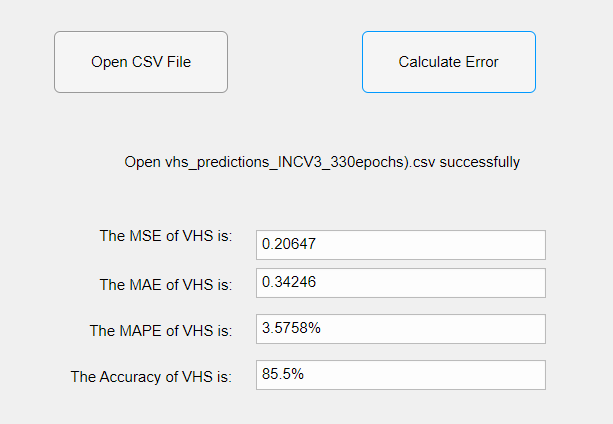

# Reached 85.5, again trying to reach more

In [1]:
from tqdm import tqdm
num_epochs_5 = 340
for epoch in range(330, num_epochs_5):
    print(f"Epoch {epoch}/{num_epochs_5 }")
    
    train_loss = train_step(model, data_loader_train, criterion, optimizer, device)
    valid_loss = valid_step(model, data_loader_valid, criterion, device)
    # Step the scheduler
    scheduler.step(valid_loss)
    if epoch % 10 == 0:
        for param_group in optimizer.param_groups:
            param_group['lr'] = param_group['lr'] * 0.5  # Halve the learning rate
    print(f"Training Loss: {train_loss:.6f}, Validation Loss: {valid_loss:.6f}")

Epoch 330/340


100%|██████████| 7/7 [00:04<00:00,  1.49it/s]


Training Loss: 0.000274, Validation Loss: 0.000158
Epoch 331/340


100%|██████████| 7/7 [00:04<00:00,  1.61it/s]


Training Loss: 0.000279, Validation Loss: 0.000159
Epoch 332/340


100%|██████████| 7/7 [00:03<00:00,  1.78it/s]


Training Loss: 0.000286, Validation Loss: 0.000160
Epoch 333/340


100%|██████████| 7/7 [00:03<00:00,  1.78it/s]


Training Loss: 0.000272, Validation Loss: 0.000158
Epoch 334/340


100%|██████████| 7/7 [00:03<00:00,  1.81it/s]


Training Loss: 0.000272, Validation Loss: 0.000158
Epoch 335/340


100%|██████████| 7/7 [00:03<00:00,  1.77it/s]


Training Loss: 0.000278, Validation Loss: 0.000160
Epoch 336/340


100%|██████████| 7/7 [00:04<00:00,  1.73it/s]


Training Loss: 0.000289, Validation Loss: 0.000159
Epoch 337/340


100%|██████████| 7/7 [00:03<00:00,  1.77it/s]


Training Loss: 0.000277, Validation Loss: 0.000159
Epoch 338/340


100%|██████████| 7/7 [00:03<00:00,  1.77it/s]


Training Loss: 0.000267, Validation Loss: 0.000159
Epoch 339/340


100%|██████████| 7/7 [00:03<00:00,  1.78it/s]

Training Loss: 0.000274, Validation Loss: 0.000158


In [2]:
from tqdm import tqdm
num_epochs_6 = 350
for epoch in range(340, num_epochs_6):
    print(f"Epoch {epoch}/{num_epochs_6 }")
    
    train_loss = train_step(model, data_loader_train, criterion, optimizer, device)
    valid_loss = valid_step(model, data_loader_valid, criterion, device)
    # Step the scheduler
    scheduler.step(valid_loss)
    if epoch % 10 == 0:
        for param_group in optimizer.param_groups:
            param_group['lr'] = param_group['lr'] * 0.5  # Halve the learning rate
    print(f"Training Loss: {train_loss:.6f}, Validation Loss: {valid_loss:.6f}")

Epoch 340/350


100%|██████████| 7/7 [00:03<00:00,  1.80it/s]


Training Loss: 0.000275, Validation Loss: 0.000158
Epoch 341/350


100%|██████████| 7/7 [00:03<00:00,  1.78it/s]


Training Loss: 0.000283, Validation Loss: 0.000160
Epoch 342/350


100%|██████████| 7/7 [00:03<00:00,  1.80it/s]


Training Loss: 0.000284, Validation Loss: 0.000161
Epoch 343/350


100%|██████████| 7/7 [00:03<00:00,  1.81it/s]


Training Loss: 0.000290, Validation Loss: 0.000159
Epoch 344/350


100%|██████████| 7/7 [00:03<00:00,  1.84it/s]


Training Loss: 0.000277, Validation Loss: 0.000160
Epoch 345/350


100%|██████████| 7/7 [00:03<00:00,  1.83it/s]


Training Loss: 0.000278, Validation Loss: 0.000159
Epoch 346/350


100%|██████████| 7/7 [00:04<00:00,  1.74it/s]


Training Loss: 0.000284, Validation Loss: 0.000159
Epoch 347/350


100%|██████████| 7/7 [00:03<00:00,  1.77it/s]


Training Loss: 0.000281, Validation Loss: 0.000159
Epoch 348/350


100%|██████████| 7/7 [00:03<00:00,  1.76it/s]


Training Loss: 0.000273, Validation Loss: 0.000158
Epoch 349/350


100%|██████████| 7/7 [00:03<00:00,  1.81it/s]

Training Loss: 0.000267, Validation Loss: 0.000158


In [3]:
from tqdm import tqdm
num_epochs_7 = 360
for epoch in range(350, num_epochs_7):
    print(f"Epoch {epoch}/{num_epochs_7 }")
    
    train_loss = train_step(model, data_loader_train, criterion, optimizer, device)
    valid_loss = valid_step(model, data_loader_valid, criterion, device)
    # Step the scheduler
    scheduler.step(valid_loss)
    if epoch % 10 == 0:
        for param_group in optimizer.param_groups:
            param_group['lr'] = param_group['lr'] * 0.5  # Halve the learning rate
    print(f"Training Loss: {train_loss:.6f}, Validation Loss: {valid_loss:.6f}")

Epoch 350/360


100%|██████████| 7/7 [00:03<00:00,  1.80it/s]


Training Loss: 0.000282, Validation Loss: 0.000159
Epoch 351/360


100%|██████████| 7/7 [00:03<00:00,  1.77it/s]


Training Loss: 0.000289, Validation Loss: 0.000158
Epoch 352/360


100%|██████████| 7/7 [00:03<00:00,  1.83it/s]


Training Loss: 0.000284, Validation Loss: 0.000159
Epoch 353/360


100%|██████████| 7/7 [00:04<00:00,  1.59it/s]


Training Loss: 0.000275, Validation Loss: 0.000160
Epoch 354/360


100%|██████████| 7/7 [00:03<00:00,  1.78it/s]


Training Loss: 0.000291, Validation Loss: 0.000159
Epoch 355/360


100%|██████████| 7/7 [00:03<00:00,  1.81it/s]


Training Loss: 0.000283, Validation Loss: 0.000159
Epoch 356/360


100%|██████████| 7/7 [00:03<00:00,  1.81it/s]


Training Loss: 0.000289, Validation Loss: 0.000159
Epoch 357/360


100%|██████████| 7/7 [00:03<00:00,  1.83it/s]


Training Loss: 0.000278, Validation Loss: 0.000158
Epoch 358/360


100%|██████████| 7/7 [00:03<00:00,  1.80it/s]


Training Loss: 0.000276, Validation Loss: 0.000159
Epoch 359/360


100%|██████████| 7/7 [00:03<00:00,  1.82it/s]

Training Loss: 0.000273, Validation Loss: 0.000159


In [6]:
torch.save({
    'epoch': epoch,  # Current epoch
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
}, 'checkpoint_INCEPV3_360epochs.pth')

In [5]:
test_path = '/kaggle/input/dog-vhs-dataset/Test_Images'
dataset_test = DogHeartDataset(test_path, get_transform(resized_image_size))
test_data_loader = torch.utils.data.DataLoader(dataset_test, batch_size=1, shuffle=False)

test_model(model, test_data_loader, 'vhs_predictions_INCV3_360epochs).csv', device)

100%|██████████| 400/400 [00:26<00:00, 15.34it/s]

Results saved to vhs_predictions_INCV3_360epochs).csv


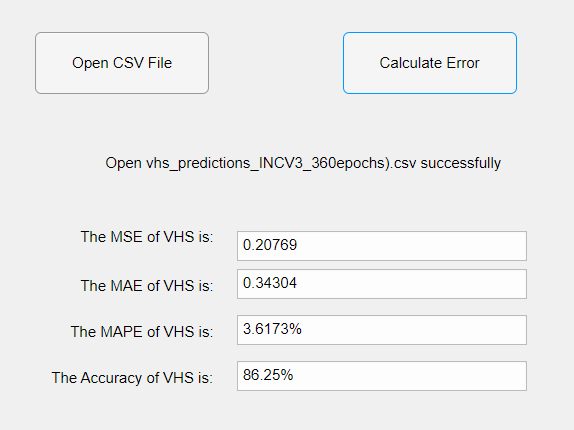

# 5. Show the comprison between predictions and ground truth
## You need to add the title with: image name, predicted VHS and Ground Truth VHS
<p align="center">
  <img src="Com.png" width="60%"> 
</p>


# Please show the comprison results of images: 1420.png, 1479.png and 1530.png from Valid dataset

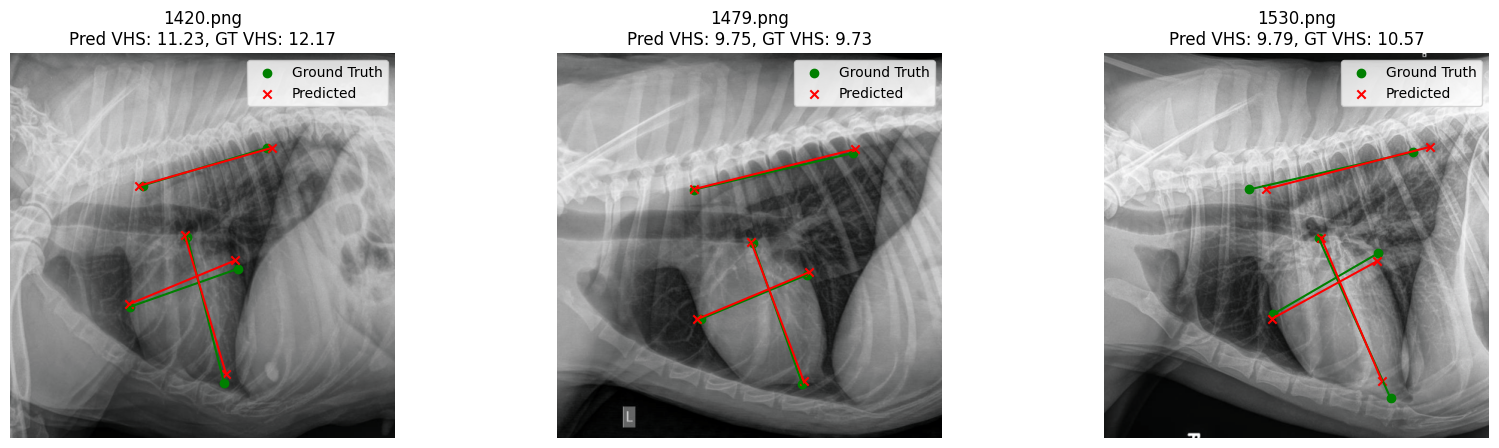

In [13]:
def visualize_specific_predictions(model, dataset, image_names, device):
    model.eval()
    fig, axes = plt.subplots(1, len(image_names), figsize=(20, 5))

    for i, image_name in enumerate(image_names):
        for idx in range(len(dataset)):
            img, points, vhs, img_name = dataset[idx]
            if img_name == image_name:
                img_tensor = img.unsqueeze(0).to(device)
                gt_points = points.cpu().numpy().reshape(-1, 2)
                gt_vhs = calculate_vhs(points)

                with torch.no_grad():
                    output = model(img_tensor)
                    if isinstance(output, tuple):
                        output = output[0]

                output = output.squeeze().cpu().numpy().reshape(-1, 2)
                pred_vhs = calculate_vhs(torch.tensor(output).flatten())

                img_np = img.permute(1, 2, 0).cpu().numpy()
                img_np = (img_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])) * 255
                img_np = img_np.astype(np.uint8)

                ax = axes[i]
                ax.imshow(img_np)
                ax.scatter(gt_points[:, 0] * img_np.shape[1], gt_points[:, 1] * img_np.shape[0], c='g', marker='o', label='Ground Truth')
                ax.scatter(output[:, 0] * img_np.shape[1], output[:, 1] * img_np.shape[0], c='r', marker='x', label='Predicted')

                # Draw lines for ground truth points
                for j in range(0, len(gt_points), 2):
                    ax.plot([gt_points[j, 0] * img_np.shape[1], gt_points[j+1, 0] * img_np.shape[1]], 
                            [gt_points[j, 1] * img_np.shape[0], gt_points[j+1, 1] * img_np.shape[0]], 'g')

                # Draw lines for predicted points
                for j in range(0, len(output), 2):
                    ax.plot([output[j, 0] * img_np.shape[1], output[j+1, 0] * img_np.shape[1]], 
                            [output[j, 1] * img_np.shape[0], output[j+1, 1] * img_np.shape[0]], 'r')

                ax.set_title(f'{image_name}\nPred VHS: {pred_vhs:.2f}, GT VHS: {gt_vhs:.2f}')
                ax.legend()
                ax.axis('off')

    plt.show()
# Load model
model = CustomInceptionV3(num_classes=12)
checkpoint_path = '/kaggle/working/checkpoint_INCEPV3_360epochs.pth'
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['model_state_dict'])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Specify images to visualize
image_names = ['1420.png', '1479.png', '1530.png']

# Visualize predictions
visualize_specific_predictions(model, dataset_valid, image_names, device)

# I also tried 

### 1. EfficientNetB7  - I got 81.75


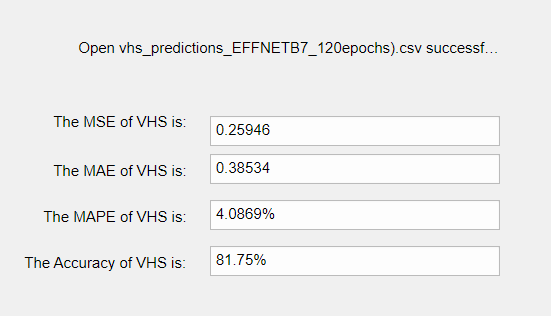

### 2. Resnet50 - I got 81.25




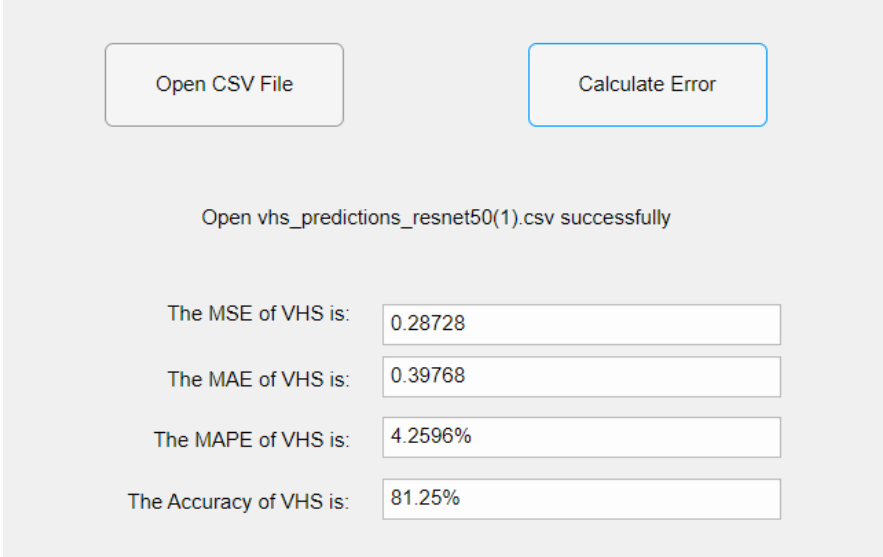

# 6. Write a three-page report using LaTex and upload your paper to ResearchGate or Arxiv, and put your paper link here.

https://www.researchgate.net/publication/382490044_Vertebral_Heart_score_Prediction_Using_Deep_Learning_-Based_Canine_Cardiomegaly

GitHub Weight Link - https://github.com/niranjankumarnk/VHS_Prediction-using-Deep-Learning/blob/main/checkpoint_INCEPV3_360epochs.pth